In [1]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# From API to Report: Building a Currency Analysis Agent with LangGraph and Gemini

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/orchestration/intro_langgraph_gemini.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Forchestration%2Fintro_langgraph_gemini.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/orchestration/intro_langgraph_gemini.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/orchestration/intro_langgraph_gemini.ipynb">
      <img width="32px" src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

| | |
|-|-|
| Author(s) | [Kristopher Overholt](https://github.com/koverholt/) |

## Overview

This notebook demonstrates how to build an AI-powered currency analysis agent using [LangGraph](https://langchain-ai.github.io/langgraph/), an orchestration framework for language models, and the [Gemini API in Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/models). This example showcases the potential of combining LangGraph's workflow capabilities with Gemini's language understanding and generation skills to streamline and automate complex financial analysis tasks. To learn more about the motivation and benefits of using LangGraph to build AI agents, refer to the [Why LangGraph?](https://langchain-ai.github.io/langgraph/concepts/high_level/) documentation.

The agent automates the process of retrieving real-time and historical exchange rates from a currency API, verifying the accuracy of the data, and generating a report summarizing the findings. By defining a structured workflow with distinct nodes for API interaction, data validation, and report generation, the agent efficiently handles each stage of the currency analysis process:

<img src="https://storage.googleapis.com/github-repo/generative-ai/gemini/orchestration/langgraph/gemini-currency-agent.jpg" width="200px">

In this notebook tutorial, you'll learn how to:

- Design and implement a multi-stage LangGraph workflow for interacting with external APIs and processing data
- Integrate the Gemini API to enable natural language understanding and report generation
- Use LangChain tools to access and query external data sources
- Validate data accuracy using Gemini's reasoning capabilities
- Generate clear and informative reports from the analyzed data

## Get started

### Install Vertex AI SDK and other required packages


In [2]:
%pip install -q -U \
    langgraph \
    langchain-google-vertexai \
    requests

### Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [3]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Wait until it's finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

If you're running this notebook on Google Colab, run the cell below to authenticate your environment.

In [4]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [5]:
import os
import vertexai

PROJECT_ID = "[your-project-id]"  # @param {type:"string", isTemplate: true}
if PROJECT_ID == "[your-project-id]":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")

vertexai.init(project=PROJECT_ID, location=LOCATION)

## Building and running the currency analysis agent

### Import libraries

This section imports the necessary libraries for LangGraph, LangChain, Vertex AI, and other utilities needed for your agent's functionality.

This includes tools for interacting with the Gemini API, defining custom tools, managing agent state, and displaying results.

In [6]:
# Standard libraries
import logging
import requests
from typing import TypedDict, Annotated

# IPython display utilities
from IPython.display import display, Image, Markdown

# LangChain core components
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.tools import tool

# Vertex AI and Gemini integration
from langchain_google_vertexai import ChatVertexAI

# LangGraph components
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

### Initialize agent state and agent memory

Here, you initialize your agent's [memory](https://langchain-ai.github.io/langgraph/how-tos/memory/manage-conversation-history/) to store information during the workflow.

You also define the schema for your [agent's state](https://langchain-ai.github.io/langgraph/how-tos/state-model/), which includes the task description and conversation history.

In [7]:
# Define the agent's state
class AgentState(TypedDict):
    task: str
    messages: Annotated[list, add_messages]


# Initialize agent memory
memory = MemorySaver()

# Set logging level to ERROR to filter warnings
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

### Initialize Gemini model

Initialize the Gemini model from Vertex AI, specifying the model version and temperature settings.

This sets up the core language model that will power your agent's actions.

In [8]:
model = ChatVertexAI(model="gemini-1.5-pro-002", temperature=0)

### Define tools

This section defines a custom tool that will be used by your agent to retrieve currency exchange rates from an external API. The tool fetches exchange rates for a specified currency pair and date.

Your LangGraph application will use this [tool node to call functions](https://langchain-ai.github.io/langgraph/how-tos/tool-calling/) and obtain information from the outside world.

In [9]:
@tool
def get_exchange_rate(
    currency_from: str = "USD",
    currency_to: str = "EUR",
    currency_date: str = "latest",
):
    """Retrieves the exchange rate between two currencies on a specified date.

    Args:
        currency_from (str, optional): The base currency. Defaults to "USD".
        currency_to (str, optional): The target currency. Defaults to "EUR".
        currency_date (str, optional): The date for the exchange rate (YYYY-MM-DD).
                                      Use "latest" for the most recent rate. Defaults to "latest".
    """
    response = requests.get(
        f"https://api.frankfurter.app/{currency_date}",
        params={"from": currency_from, "to": currency_to},
    )
    return response.json()

### Define prompts and functions for each node

Here, you define the prompts and functions that will be used for each node in the LangGraph workflow. These prompts guide the Gemini model in performing specific actions, such as retrieving exchange rates, verifying their accuracy, and generating a report.

By separating out our agent's functionality into distinct nodes, you can choose exactly which actions that node should perform and how much to defer to the LLM vs. application code in a given node. Notice how each node uses information from the global state, then updates the global state variables in the `return` statement.

In [10]:
#######################################
# Agent Node: Look up the exchange rate
#######################################


def agent_node(state: AgentState):
    messages = state["messages"]
    model_with_tools = model.bind_tools(tools)
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


#########################################
# Tool Node: Define based on API function
#########################################

tools = [get_exchange_rate]
tool_node = ToolNode(tools)


# Determine if additional tool calls are needed
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "review"


#########################################
# Review Node: Analyze and review results
#########################################

REVIEW_PROMPT = """You are a financial expert. Analyze the converted
rates and verify the correctness of the figures.
This is the conversation history so far:
{messages}"""


def review_node(state: AgentState):
    messages = [
        HumanMessage(content=REVIEW_PROMPT.format(messages=state["messages"])),
    ]
    response = model.invoke(messages)
    return {"messages": response}


########################################
# Report Node: Generate a summary report
########################################


REPORT_PROMPT = """Construct a summary report for a financial news
reporter covering current exchange rates. Include a table of results
comparing the rates over time. Do not use currency symbols in the
output since they might break the rendering of the output.
This is the conversation history so far:
{messages}"""


def report_node(state: AgentState):
    messages = [
        HumanMessage(content=REPORT_PROMPT.format(messages=state["messages"])),
    ]
    response = model.invoke(messages)
    return {"messages": response}

### Define and compile the graph

This section defines the structure of the LangGraph workflow, connecting the nodes in a logical sequence.

The graph is then compiled, incorporating your agent's memory for state management.

In [11]:
# Initialize the LangGraph workflow, specifying the agent's state schema
workflow = StateGraph(AgentState)

# Add nodes to the workflow, associating each node with its corresponding function
workflow.add_node("agent", agent_node)
workflow.add_node("tools", tool_node)
workflow.add_node("review", review_node)
workflow.add_node("report", report_node)

# Define the flow of execution between nodes, creating the workflow's logic
workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", "review"])
workflow.add_edge("tools", "agent")
workflow.add_edge("review", "report")
workflow.add_edge("report", END)

# Compile the LangGraph workflow, enabling memory-based state management
graph = workflow.compile(checkpointer=memory)

### Show the compiled graph

You can visualize the compiled LangGraph workflow using a diagram, which provides a clear overview of your agent's execution flow.

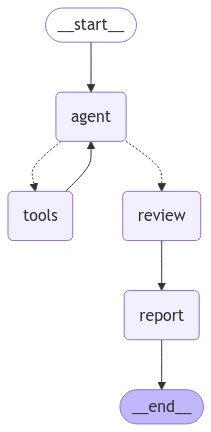

In [12]:
Image(graph.get_graph().draw_mermaid_png())

### Run the agent!

Now you're ready to initiate the workflow with a system prompt and user prompt to retrieve current and historical currency exchange rates.

Feel free to modify these prompts and see how the agent responds! Try switching countries, currencies, time periods, or other changes.

In [ ]:
# Define the system prompt instructing the agent on how to answer the user's question.
SYSTEM_PROMPT = """Use the tools provided to answer the user's question. 
Also look up the exchange rate for all currencies from three months prior
and compare the values."""

# Define the user's initial question about exchange rates.
USER_PROMPT = """What's the exchange rate from USD to (SEK, EUR, and JPY)
as of today? And how much would $100 USD be worth in those currencies?"""

Now you're ready to execute your LangGraph agent!

Now your agent will work through the nodes in the graph step-by-step to interact with the API, validate the data, and prepare a report.

In [ ]:
# Initialize a LangGraph thread with a unique ID for state management.
thread_config = {"configurable": {"thread_id": "1"}}

# Execute the LangGraph workflow, streaming the results of each node.
for state in graph.stream(
    {
        "messages": [
            SystemMessage(content=SYSTEM_PROMPT),
            HumanMessage(content=USER_PROMPT),
        ],
    },
    thread_config,
):
    # Print the name of the current node and its output for each step.
    for node_name, node_output in state.items():
        print(f"Agent Node: {node_name}\n")
        print("Agent Result:")
        print(str(node_output)[:1000])  # Truncate output for display
    print("\n====================\n")

Agent Node: agent

Agent Result:
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_exchange_rate', 'arguments': '{"currency_from": "USD", "currency_to": "JPY"}'}}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 176, 'candidates_token_count': 39, 'total_token_count': 215, 'cached_content_token_count': 0}, 'finish_reason': 'STOP'}, id='run-1d509a3d-3b8e-4eb2-97d1-1d5822aaf4cd-0', tool_calls=[{'name': 'get_exchange_rate', 'args': {'currency_from': 'USD', 'currency_to': 'SEK'}, 'id': 'd31e6ab0-d00e-4e56-b14b-224745f943d1', 'type': 'tool_call'}, {'name': 'get_exchange_rate', 'args': {'currency_from': 'USD', 'currency_to': 'EUR'}, 'id': '62649ecf-c730-406b-9340-da13fce0ed83', 'type': 'tool_call'}, {'name': 'get_exchange_rate', 'args': {'currency_from': 'USD', 'currency_to': 'JPY'}, 'id': 'b4f74745-520f-4460-82f8-61f53a4e72f7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 176, 'output_tokens'

### Render the output

Finally, you render the final report generated by your agent, displaying the results of the currency analysis in a human-readable way.

In [14]:
display(Markdown(s["report"]["messages"].content))

**Exchange Rate Summary Report – October 15, 2024**

This report summarizes the current exchange rates for USD against several major currencies, comparing them to rates from three months prior.  The data reveals notable shifts in the relative strength of the Yen against the US dollar.

**Key Observations:**

* The Japanese Yen (JPY) has weakened considerably against the USD over the past three months. This depreciation makes imports priced in USD more expensive for Japanese consumers and businesses.
* Both the Swedish Krona (SEK) and the Euro (EUR) have strengthened slightly against the USD, though these changes are less pronounced than the JPY's movement.

**Exchange Rate Table:**

| Currency Pair | Current Rate (Oct 15, 2024) | Previous Rate (Jul 15, 2024) | Change (%) |
|---|---|---|---|
| USD to SEK | 10.365 | 10.5781 | +2.01% |
| USD to EUR | 0.91718 | 0.91684 | -0.04% |
| USD to JPY | 149.36 | 158.01 | +5.47% |


**100 USD Equivalency:**

| Currency | Current Value (Oct 15, 2024) | Previous Value (Jul 15, 2024) |
|---|---|---|
| SEK | 1036.5 | 1057.81 |
| EUR | 91.72 | 91.68 |
| JPY | 14936 | 15801 |

**Data Source and Disclaimer:**

Exchange rate data was obtained via a real-time data tool. While every effort has been made to ensure accuracy, it is essential to note that exchange rates are constantly fluctuating.  For the most up-to-the-minute information, please consult a reputable financial institution or data provider.  This report is for informational purposes only and should not be considered financial advice.
